In [1]:
import Functions as func
from pydub import AudioSegment
import wave
import pickle
import numpy as np
from scipy.io import wavfile
from scipy import signal
import matplotlib.pyplot as plt
import pandas as pd
import librosa
import os
import pickle
# from cfg import config


Using TensorFlow backend.
/Applications/anaconda3/lib/python3.7/site-packages/pydub/utils.py:165: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [2]:
from keras.layers import Conv2D, MaxPool2D, Flatten, LSTM
from keras.layers import Dropout, Dense, TimeDistributed
from keras.models import Sequential
from keras.utils import to_categorical

from sklearn.utils.class_weight import compute_class_weight


In [3]:
from tqdm import tqdm
# https://github.com/jameslyons/python_speech_features
from python_speech_features import mfcc, logfbank



In [4]:
# General Variables:
main_path = '../../'
raw_data = main_path + 'rawdata/'
data_path = main_path + 'FreshStart/Data/'

### Convert Stereo to Mono audio files

In [5]:
# # Convert Stereo to Mono
# file_name = '6_HGSM3B_0+1_20150617_050600.wav'
# mysound = AudioSegment.from_wav(raw_data + file_name)
# mysound = mysound.set_channels(1)
# mysound.export(main_path + 'FreshStart/Data/Mono_Raw/' + file_name, format="wav")


### Apply low pass filter to files

In [6]:
# file_name = '6_HGSM3B_0+1_20150617_050600.wav'
# file_name_output = main_path + 'FreshStart/Data/Remez_Low_Pass/' + file_name

# # Read the audio file
# data, sr = func.read_wav(main_path + 'FreshStart/Data/Mono_Raw/' + file_name)

# # Apply the low pass filetr to the data
# taps = func.low_pass_remez(fs=sr, cutoff=2000)
# # low_pass_data_remrez = np.convolve(data, taps)
# low_pass_data_remrez = signal.convolve(, method='direct')

# # Save the filtered data
# wavfile.write(file_name_output, sr, low_pass_data_remrez)


### Preprocessing

In [5]:
# Read the csv file
# The csv contains the audio file names and their corresponding label
# fname and label
df = pd.read_csv(data_path + 'files_labels.csv')
df.set_index('fname', inplace=True)
for f in df.index:
    rate, signal = wavfile.read(data_path + f)
    df.at[f, 'length'] = signal.shape[0]/rate

# Get the classes distribution
classes=list(np.unique(df.label))
class_dist=df.groupby(['label'])['length'].sum()


/Applications/anaconda3/lib/python3.7/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


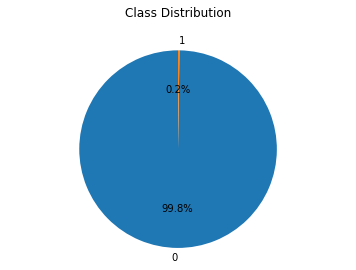

In [6]:
# Plot the distribution
fig, ax = plt.subplots()
ax.set_title('Class Distribution', y=1.08)
ax.pie(class_dist, labels=class_dist.index, autopct='%1.1f%%', shadow=False, startangle=90)
ax.axis('equal')
plt.show()
df.reset_index(inplace=True)


/Applications/anaconda3/lib/python3.7/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)
/Applications/anaconda3/lib/python3.7/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


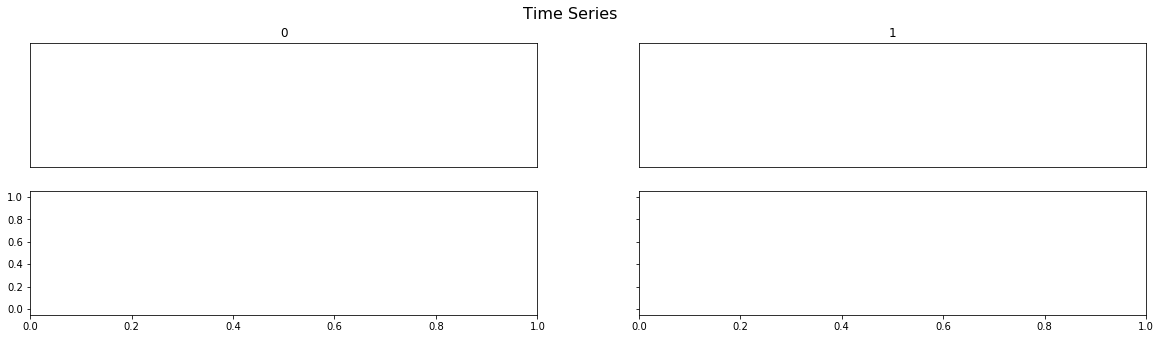

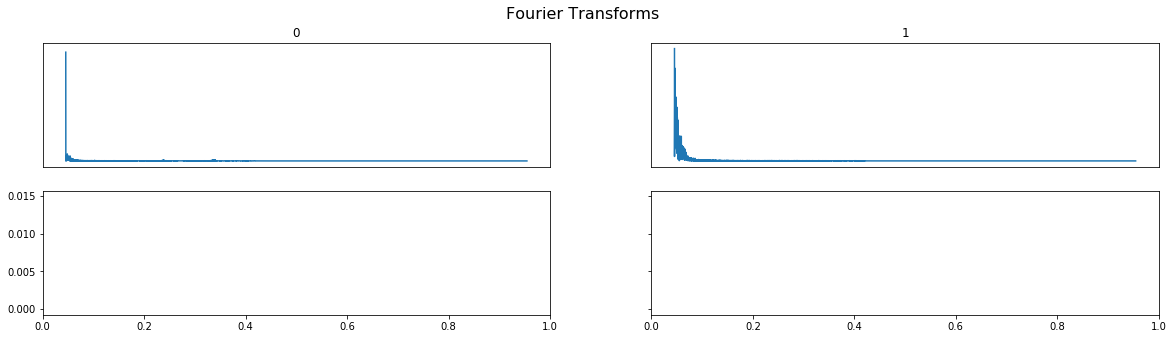

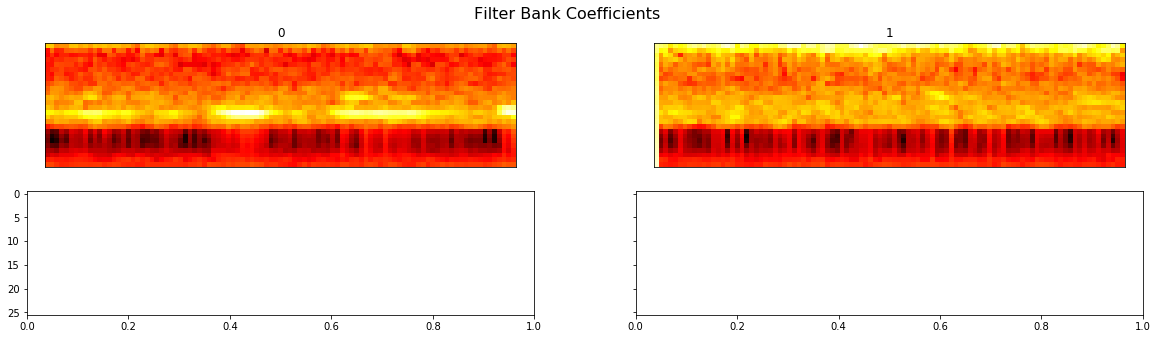

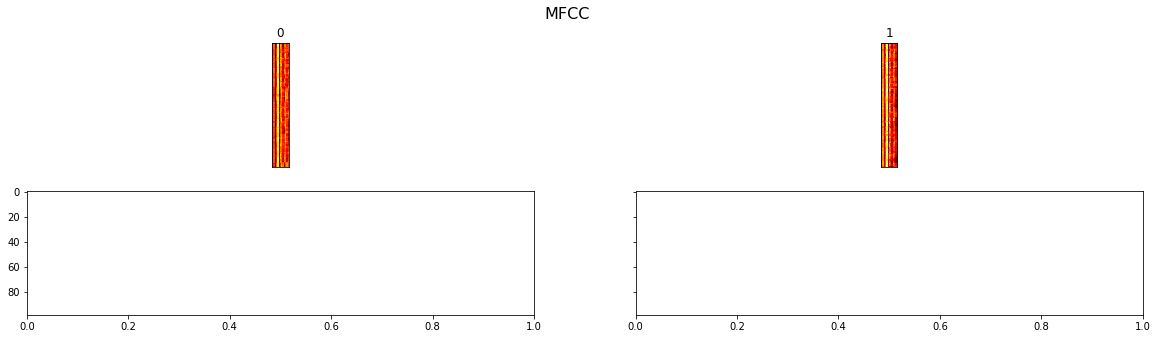

In [53]:
# Plot the fft

signals={}
fft={}
fbank={}
mfccs={}

for c in classes:
    wav_file=df[df.label==c].iloc[0, 0]
    # Get the sample rate before calling librosa
    sr, signal = wavfile.read(data_path+wav_file)
    signal, rate=librosa.load(data_path+wav_file, sr=sr, duration=5)
    
    mask=func.envelope(signal, rate, 0.0005)
    signal=signal[mask]
    
    signals[c]=signal
    fft[c]=func.calc_fft(signal, rate)
    
    # Get the log bank of 1s
    bank=logfbank(signal[:rate], rate, nfilt=26, nfft=512,winlen=0.025).T
    fbank[c]=bank
    
    # Get the MFCC
    mel=mfcc(signal[:rate], rate, numcep=13, nfilt=26, nfft=512)
    mfccs[c]=mel
    
func.plot_signals(signals)
plt.show()

func.plot_fft(fft)
plt.show()

func.plot_fbank(fbank)
plt.show()

func.plot_mfccs(mfccs)
plt.show()


In [ ]:
### if len(os.listdir(data_path+'clean')) == 0:
#     for f in tqdm(df.fname):
#         signal, rate=librosa.load(data_path+f, sr=sr)
#         mask=func.envelope(signal, rate, 0.0005)
#         filename_out=data_path+'clean/'+f.split('/')[2]
#         wavfile.write(filename=filename_out, rate=rate, data=signal[mask])

In [8]:
class Config:
    def __init__(self, mode='conv', nfilt=26, nfeat=13, nfft=512, rate=9600):
        self.mode=mode
        self.nfilt=nfilt
        self.nfeat=nfeat
        self.nfft=nfft
        self.rate=rate
        self.step=int(rate/10)

In [9]:
def build_rand_feat():
    X=[]
    y=[]
    _min, _max=float('inf'), -float('inf')
    for _ in tqdm(range(n_samples)):
        # Pick a class randomly
        rand_class=np.random.choice(class_dist.index, p=prob_dist)
        # Choose a random audio file from that class
        file_index=np.random.choice(df[df.label==rand_class].index)
        file=df[df.index==file_index].fname.iloc[0]
        file=file.split('/')[2]
        rate, wav=wavfile.read(data_path+'Clean/'+file)
        label=df.at[file_index, 'label']
        # Pick a random index to start reading from the file, with a step size
        # This is done so that the model can learn the class from a small sample of the audio file
        # Can be removed if I want to use the whole file, maybe for LSTM
        rand_index=np.random.randint(0, wav.shape[0]-config.step)
        sample=wav[rand_index:rand_index+config.step]
        # Generate the features and fill the data
        X_sample=mfcc(sample, rate, numcep=config.nfeat, nfilt=config.nfilt, nfft=config.nfft).T
        _min=min(np.amin(X_sample), _min)
        _max=max(np.amax(X_sample), _max)
        X.append(X_sample if config.mode=='conv' else X_sample.T)
        y.append(classes.index(label))
        
    # Convert to array
    X, y=np.array(X), np.array(y)
    # Normalize
    X=(X-_min)/(_max-_min)
    
    print(X.shape)
    
    # Reshape X
    if config.mode=='conv':
        X=X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
    elif config.mode=='time':
        X=X.reshape(X.shape[0], X.shape[1], X.shape[2])
    # Can remove this since I have a binary cross entropy loss function
#     y=to_categorical(y, num_classes=2)
    return X, y

In [10]:
# To install the Tensorflow with gpu support
# https://medium.com/better-programming/install-tensorflow-1-13-on-ubuntu-18-04-with-gpu-support-239b36d29070


# n_samples=2*int(df['length'].sum()/0.1)
n_samples=int((df['length'].sum()/0.1)/4000)
# prob_dist=class_dist/class_dist.sum()
prob_dist = pd.Series([0.7, 0.3], index=[0,1])
choices=np.random.choice(class_dist.index, p=prob_dist)
    


### Run the conv model

In [14]:
config=Config(mode='conv')
if config.mode=='conv':
    X, y=build_rand_feat()
    # Save the variables
    with open(data_path+'Randomized_data/convolution_data', 'wb') as f:
        pickle.dump([X, y], f)
    # Set the input shape
    input_shape=(X.shape[1], X.shape[2], 1)
    model=func.get_conv_model(input_shape)
elif config.mode=='time':
    X, y=build_rand_feat()
    # Save the variables
    with open(data_path+'Randomized_data/lstm_data', 'wb') as f:
        pickle.dump([X, y], f)
    # Set the input shape
    input_shape=(X.shape[1], X.shape[2])
    model=func.get_recurrent_model(input_shape)

100%|██████████| 72/72 [00:30<00:00,  1.69it/s]

(72, 13, 9)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 13, 9, 16)         160       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 9, 32)         4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 9, 64)         18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 9, 128)        73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 4, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 4, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3072)              0         
__________

In [13]:
# Set the class weight since the data is imbalanced
class_weight=compute_class_weight('balanced', classes, y)

In [16]:
# Fit the model
model.fit(X, y, epochs=50, batch_size=32, class_weight=class_weight, verbose=1)
model.save('mfccs_cnn_model.h5')


Instructions for updating:
Use tf.cast instead.
Epoch 1/50
72/72 [==============================] - 1s 10ms/step - loss: 0.6789 - acc: 0.6389
Epoch 2/50
72/72 [==============================] - 0s 1ms/step - loss: 0.6312 - acc: 0.6944
Epoch 3/50
72/72 [==============================] - 0s 1ms/step - loss: 0.6104 - acc: 0.6944
Epoch 4/50
72/72 [==============================] - 0s 1ms/step - loss: 0.6215 - acc: 0.6944
Epoch 5/50
72/72 [==============================] - 0s 1ms/step - loss: 0.6228 - acc: 0.6944
Epoch 6/50
72/72 [==============================] - 0s 1ms/step - loss: 0.6198 - acc: 0.6944
Epoch 7/50
72/72 [==============================] - 0s 1ms/step - loss: 0.6158 - acc: 0.6944
Epoch 8/50
72/72 [==============================] - 0s 1ms/step - loss: 0.6042 - acc: 0.6944
Epoch 9/50
72/72 [==============================] - 0s 989us/step - loss: 0.6280 - acc: 0.6944
Epoch 10/50
72/72 [==============================] - 0s 1ms/step - loss: 0.6179 - acc: 0.6944
Epoch 11/50
72/72 

### Run the LSMT model

In [12]:
config=Config(mode='time')
if config.mode=='conv':
    X, y=build_rand_feat()
    input_shape=(X.shape[1], X.shape[2], 1)
    model=func.get_conv_model(input_shape)
elif config.mode=='time':
    X, y=build_rand_feat()
    input_shape=(X.shape[1], X.shape[2])
    model=func.get_recurrent_model(input_shape)

100%|██████████| 72/72 [00:32<00:00,  2.21it/s]

(72, 9, 13)
Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 9, 128)            72704     
_________________________________________________________________
lstm_2 (LSTM)                (None, 9, 128)            131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 9, 128)            0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 9, 64)             8256      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 9, 32)             2080      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 9, 16)             528       
___________________________

In [15]:
###### Save the model
# Fit the model
model.fit(X, y, epochs=50, batch_size=32, class_weight=class_weight, verbose=1)
model.save('mfcc_lstm_model.h5')

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
72/72 [==============================] - 1s 20ms/step - loss: 0.6952 - acc: 0.3611
Epoch 2/50
72/72 [==============================] - 0s 704us/step - loss: 0.6913 - acc: 0.6250
Epoch 3/50
72/72 [==============================] - 0s 695us/step - loss: 0.6886 - acc: 0.6667
Epoch 4/50
72/72 [==============================] - 0s 694us/step - loss: 0.6807 - acc: 0.6667
Epoch 5/50
72/72 [==============================] - 0s 717us/step - loss: 0.6751 - acc: 0.6667
Epoch 6/50
72/72 [==============================] - 0s 716us/step - loss: 0.6684 - acc: 0.6667
Epoch 7/50
72/72 [==============================] - 0s 697us/step - loss: 0.6617 - acc: 0.6667
Epoch 8/50
72/72 [==============================] - 0s 712us/step - loss: 0.6460 - acc: 0.6667
Epoch 9/50
72/72 [==============================] - 0s 720us/step - loss: 0.6400 - acc: 0.6667
Epoch 10/50
72/72 [==============================] - 0s 696us/step - loss: 0.6396 - acc: 0.6667
Ep

### Connect the output of the CNN to the LSTM

In [30]:
config=Config(mode='conv')
if config.mode=='conv':
    X, y=build_rand_feat()
    input_shape=(X.shape[1], X.shape[2], 1)
    model=get_CNN_recurrent_model(input_shape)

In [29]:
###### Save the model
# Fit the model
model=method2(input_shape)
model.fit(X, y, epochs=50, batch_size=32, class_weight=class_weight, verbose=1)


### Predictions

# Using the VGGish